# Predict theft using Tourism and Female industrial sector workers

It was interesting that tourism has a linear relation to crimes theft category and females employment in industrical sector too has relation to the same crime. Hence we could be able predict crimes expected for a given district if we have these 2 dependent parameters. Even though this analysis is not predict in a time series, this results can use to predict future values if we have future values for dependent variables (tourism and female employment) in a given random district.

**Imports and workspace setting**

In [232]:
import csv
import math
import os

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stat

from sklearn import linear_model
from pandas import DataFrame 
from sklearn.model_selection import KFold

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

In [233]:
integrated_data = pd.read_csv('../data/integrated_data.csv')
integrated_data = integrated_data.drop(integrated_data.columns[[0, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17]], axis=1)
print("Data set size : ", integrated_data.shape)
integrated_data.head()

Data set size :  (26, 23)


,District,Rooms,Female emp. Industry,H.B. & Theft,Grevious Hurt,Hurt by Knife etc.,Homicide/Abet. To commit suicide,Attempted Homicide,Rape / Incest,Riot,...,"Cheating/Misappropriation C.B. Trust > Rs.100,000",Theft of Property (praedial produce > Rs.5000),Counterfeiting Currency,Offences against State,Cruelty & sexual exploitation of children,Procuration / Trafficking,Offences under the Offensive weapons Act.,Possess Automatic/ Repeater Shot Guns,"Offence under Poisons, Opium & Dangerous Drugs",2012
0,Ampara,610.0,4.1,239.0,69.0,38.0,16.0,12.0,37.0,1.0,...,232.0,242.0,1.0,0.0,1.0,2.0,1.0,0.0,1.0,648.06
1,Anuradhapura,979.0,5.5,834.0,108.0,72.0,24.0,15.0,199.0,4.0,...,270.0,584.0,6.0,0.0,23.0,2.0,4.0,1.0,7.0,856.23
2,Badulla,765.0,4.8,359.0,112.0,85.0,28.0,11.0,73.0,3.0,...,138.0,296.0,1.0,0.0,2.0,0.0,3.0,0.0,20.0,811.76
3,Batticaloa,883.0,4.0,227.0,56.0,89.0,11.0,2.0,52.0,0.0,...,225.0,221.0,1.0,0.0,6.0,3.0,1.0,1.0,3.0,525.14
4,Colombo,7519.0,20.0,2996.0,248.0,379.0,62.0,21.0,120.0,3.0,...,1736.0,2809.0,4.0,0.0,52.0,1.0,21.0,6.0,573.0,2309.81


**Normalizing theft crime data with population**

In [234]:
integrated_data['H.B. & Theft_Normalzed'] = integrated_data['H.B. & Theft']/integrated_data['2012']

**Correlation analysis to H.B. & theft**

Text(0.5, 1.0, 'Female employment in industrial sector Correlation')

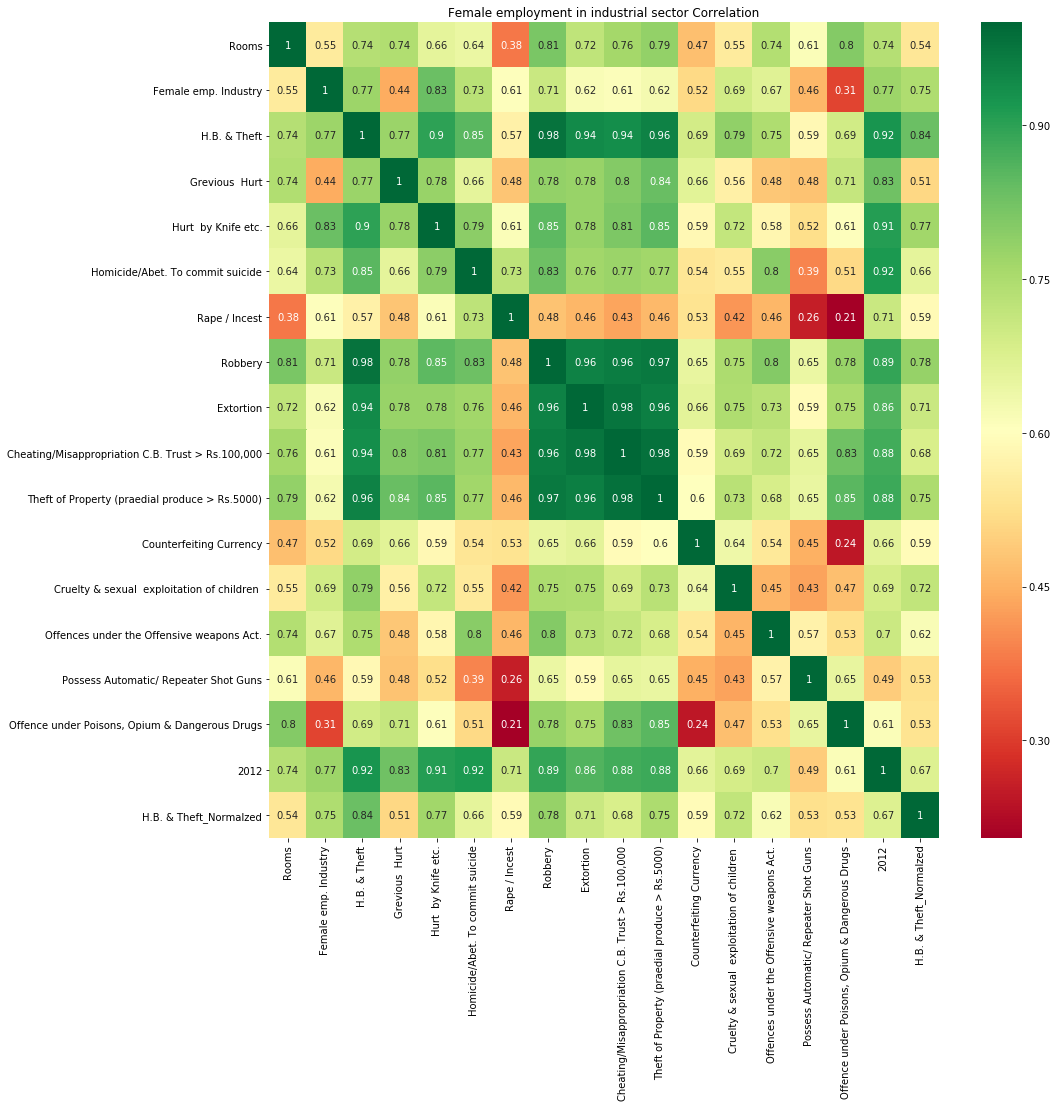

In [235]:
allCorrelations = integrated_data.corr(method='pearson')

## Extract high correlations to Drugs
topCorrFeatures = allCorrelations.index[abs(allCorrelations['H.B. & Theft_Normalzed']) >= 0.5]
plt.figure(figsize=(15,15))
ax = sns.heatmap(integrated_data[topCorrFeatures].corr(), annot=True, cmap="RdYlGn")
ax.set_title('Female employment in industrial sector Correlation')

**Female employment indistry has 0.75 correlation to H.B Theft**

**Tourism (Total room count) has 0.54 correlation to H.B Theft**

**Draw linear relationship**

C:\Users\Prageeth\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


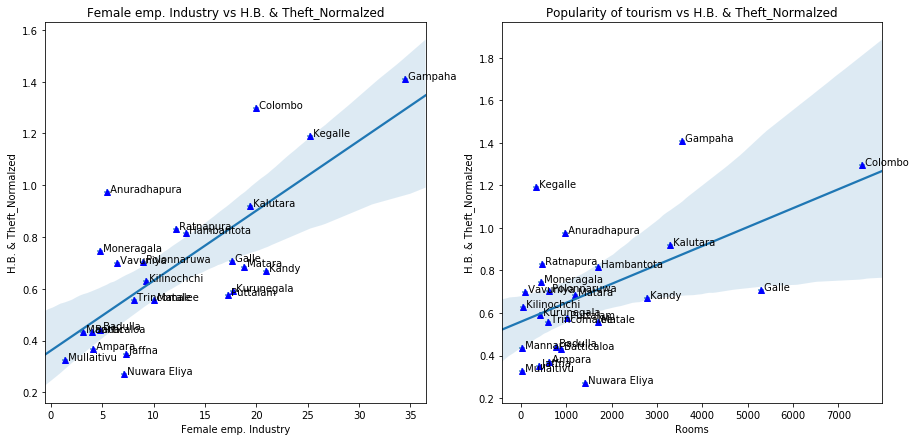

In [236]:
def plotScatterForCrime (column, tag, subPlotIndex):
    plt.subplot(1,2,subPlotIndex)
    plt.plot(integrated_data[column],  integrated_data['H.B. & Theft_Normalzed'], 'b^')

    for i, txt in enumerate(integrated_data['District']):
        if integrated_data[column][i] >= 1:
            plt.annotate(' ' + txt, (integrated_data[column][i], integrated_data['H.B. & Theft_Normalzed'][i]))
    
    x, y = pd.Series(integrated_data[column], name="x_var"), pd.Series(integrated_data['H.B. & Theft_Normalzed'], name="y_var")
    ax = sns.regplot(x=x, y=y, marker="+")
    
    plt.title(tag + ' vs H.B. & Theft_Normalzed')
    plt.xlabel(column)
    plt.ylabel('H.B. & Theft_Normalzed')

plt.figure(figsize=(15, 7))
plt.subplots_adjust(hspace=0.2)

plotScatterForCrime('Female emp. Industry', 'Female emp. Industry', 1)
plotScatterForCrime('Rooms', 'Popularity of tourism', 2)

**Linear regression to predict theft crimes using female employment in industrial sector**

In [237]:
integrated_data.dropna(inplace=True)

X = pd.DataFrame(integrated_data[['Female emp. Industry']])
y = pd.DataFrame(integrated_data[['H.B. & Theft_Normalzed']])

# model = linear_model.LinearRegression()
model = linear_model.Ridge(alpha=0.1, normalize= True)
# model = linear_model.Lasso(alpha=0.1)

scores = []
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X, y)):
 model.fit(X.iloc[train,:], y.iloc[train,:])
 score = model.score(X.iloc[test,:], y.iloc[test,:])
 scores.append(score)
np.mean(scores)

0.4913078638686361

In [238]:
# make a prediction
ynew = model.predict(X.values)
# show the inputs and predicted outputs

predictions = pd.DataFrame(columns=['X', 'Actual y', 'Predicted Y'])

for i in range(len(X.values)):
    predictions = predictions.append({'X': X.values[i], 'Actual y': y.values[i], 'Predicted Y': ynew[i]}, ignore_index=True)

predictions.head()

,X,Actual y,Predicted Y
0,[4.1],[0.3687930129926242],[0.5222967742196818]
1,[5.5],[0.974037349777513],[0.5561867536835392]
2,[4.8],[0.44224894057356856],[0.5392417639516105]
3,[4.0],[0.4322656815325437],[0.5198760614008349]
4,[20.0],[1.2970763829059533],[0.9071901124163471]


C:\Users\Prageeth\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Prageeth\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


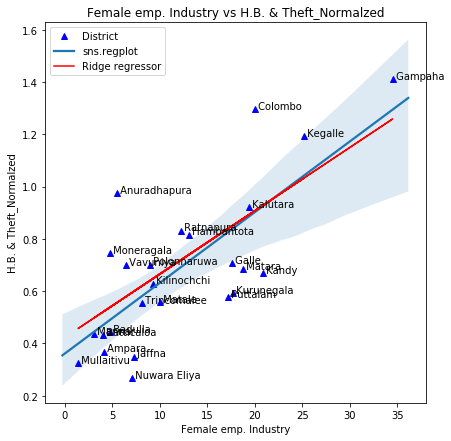

In [239]:
def plotScatterForCrime (column, tag, subPlotIndex):
    plt.subplot(1,2,subPlotIndex)
    plt.plot(integrated_data[column],  integrated_data['H.B. & Theft_Normalzed'], 'b^')

    for i, txt in enumerate(integrated_data['District']):
        if integrated_data[column][i] >= 1:
            plt.annotate(' ' + txt, (integrated_data[column][i], integrated_data['H.B. & Theft_Normalzed'][i]))
    
    x, y = pd.Series(integrated_data[column], name="x_var"), pd.Series(integrated_data['H.B. & Theft_Normalzed'], name="y_var")
    ax = sns.regplot(x=x, y=y, marker=" ")
    
    plt.title(tag + ' vs H.B. & Theft_Normalzed')
    plt.xlabel(column)
    plt.ylabel('H.B. & Theft_Normalzed')

plt.figure(figsize=(15, 7))
plt.subplots_adjust(hspace=0.2)

plotScatterForCrime('Female emp. Industry', 'Female emp. Industry', 1)

plt.subplot(1,2,1)
plt.plot(X, model.predict(X),color='r')

plt.legend(['District','sns.regplot', 'Ridge regressor'], loc='upper left')

**Linear regression to predict theft crimes using Tourism popularity**

In [240]:
integrated_data.dropna(inplace=True)

X = pd.DataFrame(integrated_data[['Rooms']])
y = pd.DataFrame(integrated_data[['H.B. & Theft_Normalzed']])

# model = linear_model.LinearRegression()
model = linear_model.Ridge(alpha=0.1, normalize= True)
# model = linear_model.Lasso(alpha=0.1)

scores = []
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X, y)):
 model.fit(X.iloc[train,:], y.iloc[train,:])
 score = model.score(X.iloc[test,:], y.iloc[test,:])
 scores.append(score)
np.mean(scores)

0.05790551823023963

C:\Users\Prageeth\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Prageeth\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


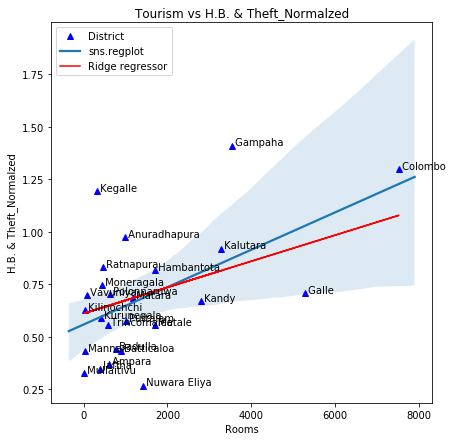

In [241]:
def plotScatterForCrime (column, tag, subPlotIndex):
    plt.subplot(1,2,subPlotIndex)
    plt.plot(integrated_data[column],  integrated_data['H.B. & Theft_Normalzed'], 'b^')

    for i, txt in enumerate(integrated_data['District']):
        if integrated_data[column][i] >= 1:
            plt.annotate(' ' + txt, (integrated_data[column][i], integrated_data['H.B. & Theft_Normalzed'][i]))
    
    x, y = pd.Series(integrated_data[column], name="x_var"), pd.Series(integrated_data['H.B. & Theft_Normalzed'], name="y_var")
    ax = sns.regplot(x=x, y=y, marker=" ")
    
    plt.title(tag + ' vs H.B. & Theft_Normalzed')
    plt.xlabel(column)
    plt.ylabel('H.B. & Theft_Normalzed')

plt.figure(figsize=(15, 7))
plt.subplots_adjust(hspace=0.2)

plotScatterForCrime('Rooms', 'Tourism', 1)

plt.subplot(1,2,1)
plt.plot(X, model.predict(X),color='r')

plt.legend(['District','sns.regplot', 'Ridge regressor'], loc='upper left')

**Using multivariate analysis to predict H.B. & theft using both tourism and female emplotment in industry**

In [242]:
integrated_data.dropna(inplace=True)

X = pd.DataFrame(integrated_data[['Rooms', 'Female emp. Industry']])
y = pd.DataFrame(integrated_data[['H.B. & Theft_Normalzed']])

# model = linear_model.LinearRegression()
model = linear_model.Ridge(alpha=0.15, normalize= True)
# model = linear_model.Lasso(alpha=0.1)

scores = []
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X, y)):
 model.fit(X.iloc[train,:], y.iloc[train,:])
 score = model.score(X.iloc[test,:], y.iloc[test,:])
 scores.append(score)
np.mean(scores)

0.5264371120113442

**Furthur tuning and feature incorporation should be done to predict Theft more accurately since 0.526 score is a moderate value.**